#Mount Google Drive

This will allow the Colab machine to access Google Drive folders by mounting the drive on the machine. You will be asked to copy and paste an authentication code.

In [55]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# Change directory to allow imports


In [56]:
import os
os.chdir("/content/gdrive/My Drive/BoxDistContinued/")
!ls

Data  Documentation  Models  output  Outputs  References


##Import Libraries

In [57]:
# import some common libraries
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import datetime
import random
import json
import cv2
import csv
import os
import h5py as h5

# import some common pytorch utilities
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch

##Set Directory

In [58]:
BASE_DIR = '/content/gdrive/My Drive/BoxDistContinued/'
TRAINING_DIR = os.path.join(BASE_DIR, 'Data/kitti/training')

#Experiments

###Load in annotations with obj_id first

In [59]:
import pycocotools
import tensorflow as tf
from skimage import measure

class_ids = {
    'Car': 0,
    'Van': 1,
    'Truck': 2,
    'Pedestrian': 3,
    'Person': 4,
    'Cyclist': 5,
    'Tram': 6,
}
def obj_id_first_annotations(set_names, poly_from_json=True):
  annotations = {}
  kitti_anno_dir = os.path.join(TRAINING_DIR, 'label_02')
  tracking_anno_dir = os.path.join(TRAINING_DIR, 'instances_txt')
  tf_anno_dir = os.path.join(TRAINING_DIR, 'instances')
  gps_anno_dir = os.path.join(TRAINING_DIR, 'oxts')
  file_name_template = '0000'
  for set_name in set_names:
    #set_name = file_name_template + str(s)
    #set_name = set_name[len(set_name)-4:len(set_name)]
    kitti_anno_file = os.path.join(kitti_anno_dir, set_name+'.txt')
    tracking_anno_file = os.path.join(tracking_anno_dir, set_name+'.txt')
    gps_anno_file = os.path.join(gps_anno_dir, set_name+'.txt')
    records = {}

#Load IMU Annotations
    gps_anno = open(gps_anno_file, 'r')
    gps_lines = gps_anno.readlines()
    gps = {}
    for frame, line in enumerate(gps_lines):
      e = line.split(' ')
      h = float(e[5])
      v = [float(e[8]), float(e[9]), float(e[10])]
      a = [float(e[14]), float(e[15]), float(e[16])]
      w = [float(e[20]), float(e[21]), float(e[22])]
      gps[frame] = {
          'v': v,
          'a': a,
          'w': w,
          'h': h,
      }
    
    tracking_anno = open(tracking_anno_file, 'r')
    tracking_lines = tracking_anno.readlines()
    line = tracking_lines[0]
    e = line.split(' ')
    frame = int(e[0])
    height = int(e[3])
    width = int(e[4])

#Load Kitti Annotations
    kitti_anno = open(kitti_anno_file, 'r')
    kitti_lines = kitti_anno.readlines()
    for line in kitti_lines:
      e = line.split(' ')
      class_name = e[2]
      trunc = float(e[3])
      occl = int(e[4])
      if class_name == 'DontCare' or class_name == 'Misc' or trunc > 0.0 or occl > 0: #data exclusion
        continue
      frame = int(e[0])
      obj_id = int(e[1])
      if obj_id not in records.keys():
        records[obj_id] = {}
      if frame not in records[obj_id].keys():
        records[obj_id][frame] = {}
      records[obj_id]['class_name'] = class_name
      records[obj_id][frame] = {
          'img_id': set_name+str(frame),
          'class_name': class_name,
          'class_id': class_ids[class_name],
          'alpha': float(e[5]),
          'bbox': [float(e[6]), float(e[7]), float(e[8]), float(e[9])],
          'xyz': [float(e[13]), float(e[14]), float(e[15])],
          'wlht': [float(e[10]), float(e[11]), float(e[12]), float(e[16])],
          'v': gps[frame]['v'],
          'a': gps[frame]['a'],
          'w': gps[frame]['w'],
          'h': gps[frame]['h'],
          'height': height,
          'width': width,
      }
      records[obj_id][frame]['instance_img'] = TRAINING_DIR + '/objs_raw/' + set_name + '/' + str(obj_id) + '/' + str(frame) + '.h5'
      #print(TRAINING_DIR + '/objs_raw/' + set_name + '/' + str(obj_id) + '/' + str(frame) + '.h5')

#Load Segmentation
    if poly_from_json:
      with open(TRAINING_DIR+'/seg_poly/'+set_name+'.json', 'r') as anno_json:
        imgs_anns = json.load(anno_json)
        for ann in imgs_anns:
          frame = ann['frame']
          obj_id = ann['obj_id']
          if obj_id not in records.keys() or frame not in records[obj_id].keys():
            continue
          records[obj_id][frame]['height'] = ann['height']
          records[obj_id][frame]['width'] = ann['width']
          records[obj_id][frame]['poly'] = ann['poly']
      anno_json.close()

#Get Instance Image Path
    annotations[set_name] = records
  return annotations

In [60]:
set_names = ['0002', '0006', '0007', '0008', '0010', '0013', '0014', '0016', '0018']
obj_first_annotations = obj_id_first_annotations(set_names)

###Cherry Pick Datasets

Requirements: has to have more than 2 or more frames

In [61]:
def cherry_pick_data(annotations, lookback=1, class_targets=None, class_excludes=None):
  cherrypicked = {}
  for scene in annotations.keys():
    cherrypicked[scene] = {}
    for obj_id in annotations[scene].keys():
      frames = annotations[scene][obj_id].keys()
      class_name = annotations[scene][obj_id]['class_name']
      if len(frames)-1 < lookback+1 or (class_targets != None and class_name not in class_targets) or (class_excludes != None and class_name in class_excludes):
        continue
      cherrypicked[scene][obj_id] = annotations[scene][obj_id]
  return cherrypicked

###Construct pairwise annotations

In [62]:
def nframe_lookback(annotations, n):
  n = n+1
  pair_wise_anno = []
  for scene in annotations.keys():
    for obj_id in annotations[scene].keys():
      frames = list(annotations[scene][obj_id].keys())
      class_name = annotations[scene][obj_id]['class_name']
      frames.remove('class_name')
      frames.sort()
      for f in range(len(frames)-n):
        data = {
            'vs': [],
            'as': [],
            'ws': [],
            'hs': [],
            'box_hs': [],
            'gts': [],
            'ce': [],
            'instance_img': [],
        }
        for i in range(n):
          frame = annotations[scene][obj_id][frames[f+i]]
          bbox = [frame['bbox'][0], frame['bbox'][1], frame['bbox'][2], frame['bbox'][3]]
          box_h = bbox[3] - bbox[1]
          v = frame['v']
          a = frame['a']
          w = frame['w']
          height = frame['height']
          width = frame['width']
          img_center = [width/2, height/2]
          bw = bbox[2] - bbox[0]
          bh = bbox[3] - bbox[1]
          ce = [(frame['bbox'][0]+(bw/2)-img_center[0])/(width/2), (frame['bbox'][1]+(bh/2)-img_center[1])/(height/2)]

          data['vs'].append(v)
          data['as'].append(a)
          data['ws'].append(w)
          data['hs'].append(frame['h'])
          data['box_hs'].append(box_h)
          data['ce'].append(ce)
          data['gts'].append(annotations[scene][obj_id][frames[f+n]]['xyz'][2])

          data['instance_img'].append(frame['instance_img'])

        dist = annotations[scene][obj_id][frames[f+n]]['xyz']
        pair = {
            'input': data,
            'output': dist,
            'debug': [annotations[scene][obj_id][frames[f]]['xyz'][2], annotations[scene][obj_id][frames[f+int(n/2)]]['xyz'][2], annotations[scene][obj_id][frames[f+n]]['xyz'][2]],
            'class': class_name,
        }
        pair_wise_anno.append(pair)
  return pair_wise_anno


###Loader

####Multi-Class train & test

In [63]:
import random
random.seed()

n=10
anno = cherry_pick_data(obj_first_annotations, n, class_targets=['Car'])
dataset = nframe_lookback(anno, n)
inputs = []
outputs = []
debugs = []
classes = []
for d in dataset:
  inputs.append(d['input'])
  outputs.append(d['output'])
  debugs.append(d['debug'])
  classes.append(d['class'])

print("Total: {} entries".format(len(inputs)))

Total: 3240 entries


####Stage 1 Input Construction

In [64]:
import math
test_input = []
test_output = []
for i in range(len(inputs)):
  target = outputs[i]
  input = inputs[i]
  debug = debugs[i]
  class_name = classes[i]

  vs = input['vs']
  vds = input['as']
  ws = input['ws']
  bhs = input['box_hs']
  ces = input['ce']

  
  input = {
      '2D': [input['instance_img'][0], input['instance_img'][int(n/2)], input['instance_img'][n]],
      '1D': vs[0] + vs[int(n/2)] + vs[n] + vds[0] + vds[int(n/2)] + vds[n] + ws[0] + ws[int(n/2)] + ws[n] + ces[0] + ces[int(n/2)] + ces[n],
      'output': target,
      'class': class_name,
  }

  #if abs(debug[2]-debug[0])/target[2] < 0.01:
  test_input.append(input)
  test_output.append(torch.from_numpy(np.expand_dims(np.array(target).astype(np.float32), axis=0)))

###Network

In [65]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

def crop_pad(image, width=224, height=224):
  h, w = image.shape
  if h < height:
    image = cv2.copyMakeBorder(image, int((height-h)/2)+(height-h)%2, int((height-h)/2),0,0,cv2.BORDER_CONSTANT,value=[0,0,0])
  if w < width:
    image = cv2.copyMakeBorder(image,0,0,int((width-w)/2)+(width-w)%2, int((width-w)/2),cv2.BORDER_CONSTANT,value=[0,0,0])
  elif w > width:
    image = image[:, int((w-width)/2)+(w-width)%2:width+int((w-width)/2)+(w-width)%2]
  return image

def img_batch_con(inputs, num_imgs=3):
  batch = np.zeros((len(inputs), num_imgs, 224, 224))
  for i, input in enumerate(inputs):
    paths = input['2D']
    pre_tensor = np.zeros((num_imgs, 224, 224))
    imgs = {}
    shapes = []
    for j, path in enumerate(paths):
      f = h5.File(path, 'r')
      img = np.array(f['img'][:,:])
      if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      h, w = img.shape
      shapes.append(h)
      imgs[j] = img
    for j in range(num_imgs):
      resized = crop_pad(image_resize(imgs[j], height=round(224*shapes[j]/max(shapes))))
      pre_tensor[j,:,:] = resized.astype(np.float32)/255.0

    batch[i,:,:,:] = pre_tensor

  batch = torch.from_numpy(batch.astype(np.float32)).cuda()
  return batch

def batch1D_con(inputs, interms):
  batch = np.zeros((len(inputs), 1000+33))
  for i, input in enumerate(inputs):
    D1 = input['1D']
    interm = interms[i].cpu().detach().numpy()
    combine = np.concatenate((interm, D1))
    batch[i,:] = combine
  batch = torch.from_numpy(batch.astype(np.float32)).cuda()
  return batch

def batch_output_con(inputs):
  batch = np.zeros((len(inputs), 3))
  for i, input in enumerate(inputs):
    batch[i,:] = np.array(input['output']).astype(np.float32)
  batch = torch.from_numpy(batch.astype(np.float32)).cuda()
  return batch

In [66]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

net2D = models.resnet18().cuda()

class CalcDist1D(nn.Module):
  def __init__(self):
    super(CalcDist1D, self).__init__()

    self.fc_net = nn.Sequential(
      nn.Linear(1000+33, 500),
      nn.LayerNorm(500),
      nn.Softplus(),
      nn.Linear(500, 250),
      nn.LayerNorm(250),
      nn.Softplus(),
      nn.Linear(250, 3),
    )
  def forward(self, x):
    x = self.fc_net(x)
    return x

net1D = CalcDist1D().cuda()

criterion = nn.L1Loss()

In [67]:
net2D.load_state_dict(torch.load("/content/gdrive/My Drive/BoxDistContinued/Models/trained/EndDist_res18_sp_2D_supcar_10.pt"))
net1D.load_state_dict(torch.load("/content/gdrive/My Drive/BoxDistContinued/Models/trained/EndDist_res18_sp_1D_supcar_10.pt"))

<All keys matched successfully>

In [68]:
import math
def dist_3D(xyz):
  x = xyz[0][0]
  y = xyz[0][1]
  z = xyz[0][2]
  return math.sqrt(x**2+y**2+z**2)

mean_error = 0
mean_dist = 0
abs_errors = []
rel_errors = []
dists = []
rmse = []
loss = 0

results = []

net2D.eval()
net1D.eval()
with torch.no_grad():
  for i in range(len(test_input)):
    input = test_input[i]
    target = test_output[i].cuda()

    input2D = img_batch_con([input])
    interm = net2D(input2D)

    input1D = batch1D_con([input], interm)
    output = net1D(input1D)

    loss += criterion(output, target)

    dist_tar = dist_3D(target.cpu().detach().numpy())
    dist_out = dist_3D(output.cpu().detach().numpy())

    results.append({
          'pred': dist_out,
          'targ': dist_tar,
          'class': input['class']
      })

    abs_errors.append(abs(dist_tar-dist_out))
    rel_errors.append(abs((dist_tar-dist_out)/dist_tar))
    dists.append(dist_tar)

    rmse.append((dist_tar-dist_out)**2)

print('loss: %.3f' %(loss/len(test_input)))
mean_error /= len(test_input)
print('mean test absolute error: %.3f' %(np.mean(abs_errors)))
mean_dist /= len(test_input)
print('mean test relative error: %.3f' %(np.mean(rel_errors)))
print('median test absolute error: %.3f' %(np.median(np.sort(abs_errors))))
print('median test relative error: %.3f' %(np.median(np.sort(rel_errors))))
rmse = sum(rmse)
rmse /= len(abs_errors)
rmse = math.sqrt(rmse)
print('rmse: %.3f' %(rmse))

loss: 2.531
mean test absolute error: 6.503
mean test relative error: 0.200
median test absolute error: 4.950
median test relative error: 0.176
rmse: 8.976


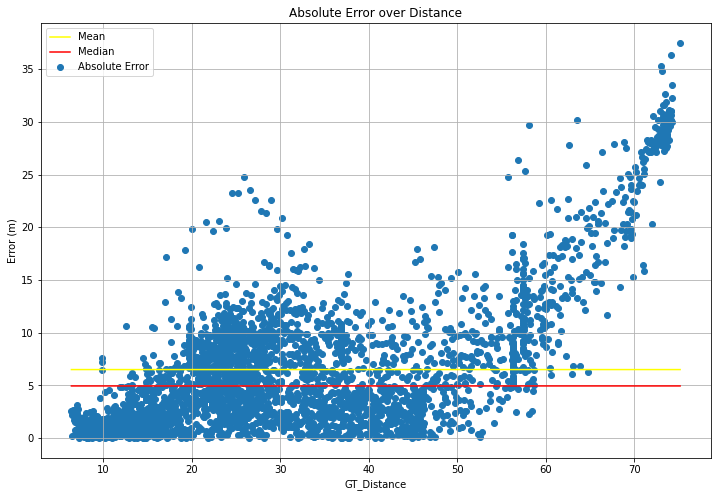

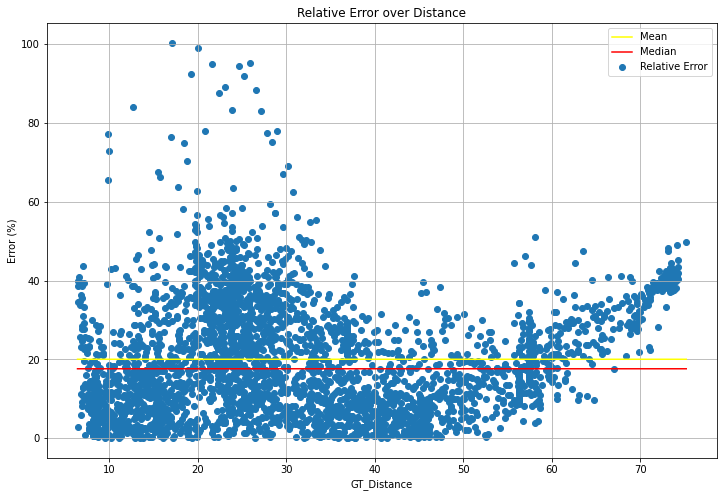

In [69]:
import matplotlib
import matplotlib.pyplot as plt

ordered_abs = [x for _, x in sorted(zip(dists, abs_errors))]
ordered_rel = [x for _, x in sorted(zip(dists, rel_errors))]

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax.scatter(np.sort(dists), np.array(ordered_abs), label='Absolute Error')
p = np.poly1d(np.polyfit(dists, ordered_abs, 10))
xp = np.linspace(min(dists), max(dists), len(dists))
#ax.plot(xp, p(xp), color='orange')
ax.plot(np.sort(dists), np.array([np.mean(abs_errors)]*len(ordered_abs)), color='yellow', label='Mean')
ax.plot(np.sort(dists), np.array([np.median(np.sort(abs_errors))]*len(ordered_abs)), color='red', label='Median')
ax.set(xlabel='GT_Distance', ylabel='Error (m)',
       title='Absolute Error over Distance')
ax.grid()
ax.legend()
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax.scatter(np.sort(dists), np.array(ordered_rel)*100, label='Relative Error')
p = np.poly1d(np.polyfit(dists, np.array(ordered_rel)*100, 10))
xp = np.linspace(min(dists), max(dists), len(dists))
#ax.plot(xp, p(xp), color='orange')
ax.plot(np.sort(dists), np.array([np.mean(rel_errors)*100]*len(ordered_abs)), color='yellow', label='Mean')
ax.plot(np.sort(dists), np.array([np.median(np.sort(rel_errors))*100]*len(ordered_abs)), color='red', label='Median')
ax.set(xlabel='GT_Distance', ylabel='Error (%)',
       title='Relative Error over Distance')
ax.grid()
ax.legend()
plt.show()

In [70]:
import csv

with open('/content/gdrive/My Drive/BoxDistContinued/Models/EndDist/Results/res18_sp_gt_const.csv', 'w', newline='') as csvfile:
    fieldnames = ['class', 'target', 'prediction']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for r in results:
      writer.writerow({'class': r['class'], 'target': r['targ'], 'prediction': r['pred']})


In [71]:
!ls '/content/gdrive/My Drive/BoxDistContinued/Models/EndDist/Results/'

res18_sp_emot.csv	   res18_sp_gt.csv	       res18_sp_supcar_5.csv
res18_sp_emot_ex.csv	   res18_sp_gt_occl.csv        res18_sp_supcar_car.csv
res18_sp_emot_ex_occl.csv  res18_sp_sanscar_car.csv    res18_sp_supcar.csv
res18_sp_gt_car.csv	   res18_sp_supcar_50_car.csv  res18_sp_tr.csv
res18_sp_gt_carped.csv	   res18_sp_supcar_50.csv      res18_sp_tr_tr.csv
res18_sp_gt_const.csv	   res18_sp_supcar_5_car.csv   segdist_gt.csv
